In [177]:
import numpy as np
import marshal, json
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches as patches
import matplotlib
import json, math
from operator import sub
import scipy.stats
from IPython.display import set_matplotlib_formats
from IPython.display import Image
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.latex.preamble': r'\usepackage{amsmath}'
})

In [178]:
def get_result(v, num_nodes, run, txd):
    with open(f'../res/v{v}_parsed/summary_collision_n{num_nodes}_txd{txd}_r{run}.json') as f:
        data = json.load(f)
        return data

In [179]:
def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio


In [180]:
def get_nc_rdf_traffic_density(n, i, q, mg, r):
    num_sent = 0
    num_fwd = 0

    A = n/12
    T = 50#math.sqrt(A) * 1000 / 33.3
    AT = A * T

    try:
        with open(f'../res/v306_parsed/summary_kpi_rdf_n{n}_i{i}_q{q}_mg{mg}_r{r}.json', 'rb') as f:
            data = json.load(f)
            num_sent = data['num_sent']
            num_fwd = data['num_fwd']
    except:
        pass

    return (num_sent + num_fwd) / AT

def get_nc_rdf_loss_rate(n, i, q, mg, r):
    try:
        with open(f'../res/v306_parsed/summary_kpi_rdf_n{n}_i{i}_q{q}_mg{mg}_r{r}.json', 'rb') as f:
            data = json.load(f)
            lr = data['avg_loss_rate']
            if lr > 0:
                return lr * 100
    except:
        pass

    return 0

def get_experienced_data():
    rdf_loss_rates = [61, 47, 55, 50, 42, 48, 32]
    rdf_traffic_densities = [2066.46612053,  1162.56352093, 1524.28139686, 1230.16928957, 930.19749241, 1115.66717616, 530.99177612]

    for r in range(5):
        for mg in [0, 10, 20, 30, 40, 50, 60, 70, 80,90, 100]:
            for n in [100, 200, 300]:
                for q in [100, 150, 200]:
                    lr_i = get_nc_rdf_loss_rate(n, 120, q, mg, r)
                    txd_i = get_nc_rdf_traffic_density(n, 120, q, mg, r)

                    if lr_i > 0 and txd_i > 0:
                        rdf_loss_rates.append(lr_i) 
                        rdf_traffic_densities.append(txd_i)

    return (rdf_traffic_densities, rdf_loss_rates)



In [181]:
(rdf_traffic_densities, rdf_loss_rates) = get_experienced_data()

In [182]:
files_missing = 0
n = 61
v = 400
n_runs = 500
collision_rates = [[0]]

synth_loss_rates = []
synth_traffic_densities = []

txd_errors = []

txds = range(100, 10050, 100)
for txd in txds:
    c = []
    for r in range(0, n_runs):
        try:
            data = get_result(v, n, r, txd)
            cr = data['collision_rate']
            if cr > -1:
                c.append((cr) * 100)
                synth_loss_rates.append(cr * 100)
                synth_traffic_densities.append(data['num_sent'] / (59 * (2.5* 0.509)**2 * math.pi))
                txd_errors.append((txd- data['num_sent'] / (59 * (2.5* 0.509)**2 * math.pi)) / txd)
        except:
            files_missing += 1
    collision_rates.append(np.array(c))

collision_rates_m = np.array([np.mean(xi) for xi in collision_rates])
txds = [0] + list(txds)

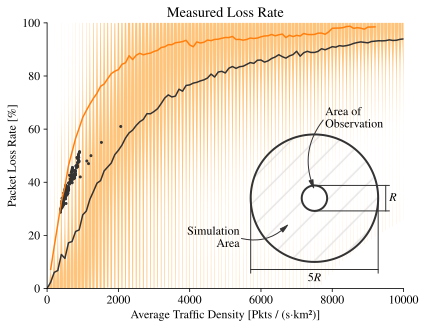

In [183]:
color='#ffb55a'

fig, ax = plt.subplots()
violin_parts = ax.violinplot(collision_rates, txds, widths=90, showmeans=False, showmedians=False, showextrema=False, bw_method=0.5)


for pc in violin_parts['bodies']:
    pc.set_facecolor(color)
    pc.set_alpha(0.8)
    #pc.set_edgecolor('#7eb0d5')

ax.plot(txds, collision_rates_m, color='#333')

ax.scatter(rdf_traffic_densities, rdf_loss_rates, s=4, c="#333")
# ax.scatter(synth_traffic_densities, synth_loss_rates, s=4, c="#ebebeb")

bins = range(50, 10050, 100)
bin_means, bin_edges, _ = scipy.stats.binned_statistic(synth_traffic_densities, synth_loss_rates, statistic='mean', bins=bins)
bin_centers = (bin_edges[1:] + bin_edges[0:-1]) / 2

ax.plot(bin_centers, bin_means)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

    #plt.plot([positions[0], positions[-1]], [collision_rates_m[0], collision_rates_m[-1]], color='#333', label=f'i={i}')
ax.set_ylim(0, 100)
ax.set_xlim(0, 10000)
ax.set_ylabel('Packet Loss Rate [\%]')
ax.set_xlabel('Average Traffic Density [Pkts / (s$\cdot$km²)]')

aspect = get_aspect(ax)
R = 9.6
height = 5 * R

x_center = 7500
y_center = 34

center = (x_center, y_center)
inner_circle_ratio = 5

outer_circle = matplotlib.patches.Ellipse(center, width=height * aspect, height=height, fill=False, lw=1, ec='#dadada', hatch="/",  clip_on=False)
ax.add_patch(outer_circle)
outer_circle = matplotlib.patches.Ellipse(center, width=height * aspect, height=height, fill=False, lw=2, ec='#333', clip_on=False)
ax.add_patch(outer_circle)
inner_circle = matplotlib.patches.Ellipse(center, width=height * aspect / inner_circle_ratio, height=height / inner_circle_ratio, fill=True, lw=2, ec='#333', fc="#fff",  clip_on=False)
ax.add_patch(inner_circle)
ax.plot([x_center, x_center + 2100],[y_center + R /2, y_center + R /2], lw =1, color='#333')
ax.plot([x_center, x_center + 2100],[y_center - R /2, y_center - R /2], lw =1, color='#333')
ax.plot([x_center + 2000, x_center + 2000],[y_center + R /2, y_center - R /2], lw =1, color='#333')
ax.text(x_center + 2100, y_center, '$R$', va='center', ha='left')

ax.plot([x_center + 2.5 * R * aspect, x_center + 2.5 * R *aspect],[y_center, y_center - 2100/aspect], lw =1, color='#333')
ax.plot([x_center - 2.5 * R * aspect, x_center - 2.5 * R *aspect],[y_center, y_center - 2100/aspect], lw =1, color='#333')
ax.plot([x_center - 2.5 * R * aspect, x_center + 2.5 * R *aspect],[y_center - 2000 / aspect, y_center - 2000 / aspect], lw =1, color='#333')
ax.text(x_center, y_center - 2100 / aspect, '$5R$', va='top', ha='center')
#ax1.plot([n-2.3, n-0.6, n+3],[-0.5, -0.58, -0.4], color='#fff', lw=1)


ax.text(x_center + 300, y_center + 30, 'Area of \nObservation', va='center', ha='left')
arrow = patches.FancyArrowPatch((x_center + 280, y_center + 30), (x_center, y_center + R / 3), connectionstyle=f"arc3,rad=0.3", arrowstyle="Simple, tail_width=0, head_width=4, head_length=8", color='#333', zorder=2)
ax.add_patch(arrow)


ax.text(x_center - 2100, y_center - 15, 'Simulation \nArea', va='center', ha='right')
arrow = patches.FancyArrowPatch((x_center - 2100, y_center -15), (x_center - R * aspect, y_center - R), connectionstyle=f"arc3,rad=0.3", arrowstyle="Simple, tail_width=0, head_width=4, head_length=8", color='#333', zorder=2)
ax.add_patch(arrow)
# ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
# ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
plt.title('Measured Loss Rate')


fig.savefig(f"../figures/collision_rate_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/collision_rate_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

plt.show()


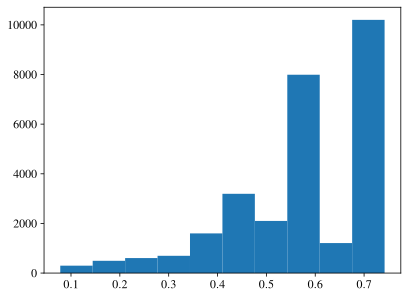

In [184]:
fig, ax = plt.subplots()
ax.hist(txd_errors)

plt.show()